# PIK3CA trans effects on known interacting proteins

We first investigated the effects of PIK3CA mutation on the proteomics and phosphoproteomic of known interacting proteins. This list primarily included proteins in the PI3K/AKT/MTOR signaling cascade that plays a key role in cell survival and cell proliferation.

## Standard Imports

In [7]:
import pandas as pd
import numpy as np
import re
import scipy.stats
import statsmodels.stats.multitest
import matplotlib.pyplot as plt
import seaborn as sns

#import the Endometrial data from CPTAC package
import CPTAC.Endometrial as CPTAC

### Set up initial dataframes and variables

In [8]:
gene = 'PIK3CA'
somatic = CPTAC.get_somatic()
proteomics = CPTAC.get_proteomics()
phos = CPTAC.get_phosphoproteomics()

#A list of mutations present in the hotspot according to our Hotspot3D output
hotspot_mutations = ['p.E545A', 'p.E545K', 'p.E545V', 'p.Q546P', 'p.Q546R', 'p.E542K']
mutated_hotspot = somatic.loc[(somatic['Location'].isin(hotspot_mutations)) & (somatic['Gene'] == gene)]
hotspot_patients = mutated_hotspot['Clinical_Patient_Key']

hotspot_patients_both_keys = mutated_hotspot[['Clinical_Patient_Key', 'Patient_Id']]
hotspot_patients = hotspot_patients_both_keys['Clinical_Patient_Key']
print(hotspot_patients)

#The pvalue cutoff used to find significance
pcutoff = 0.05


160      S001
1147     S003
1426     S009
4757     S021
16613    S023
19188    S024
21386    S032
21643    S033
22656    S038
37618    S061
38352    S063
39719    S066
43588    S067
43687    S068
46859    S084
47557    S088
48398    S090
49903    S097
50016    S098
Name: Clinical_Patient_Key, dtype: object


## Find number of patients with PIK3CA mutations in/outside of the hotspot

In [9]:
print("Mutations inside hotspot: " + str(len(hotspot_patients)))
p110_mutated = somatic.loc[somatic['Gene'] == 'PIK3CA']
#note: the gene PIK3CA encodes for the protein p110α, hence the variable 'p110_mutated'

# This naturally includes a value that is 'NA' so we subtract 1
# Some people have more than one mutation so we need to grab the unique values
num_mutated = len(set(p110_mutated['Clinical_Patient_Key'])) - 1
print("Total number of patients with mutations: " + str(num_mutated))

Mutations inside hotspot: 19
Total number of patients with mutations: 48


# Proteomic Abundance

### List of proteins that interact with PIK3CA (according to Uniprot and STRING)

In [10]:
#Build the protein list; this may have only a single protein if desired
protList = ['IRS1', 'IRS2', 'RRAS', 'AKT2', 'NRAS', 'PTEN', 'AKT1', 'MRAS', 'HRAS', 'RPS6KB1', 'PIK3R1', 'PKC', 'MTOR', 'S6K', 'MAPK', 'ERBB3', 'P85A', 'P55G', 'CDK5']

## Hotspot mutation vs non-hotspot mutation

In [11]:
print("Mutations inside hotspot: " + str(len(hotspot_patients)))
p110_mutated = somatic.loc[somatic['Gene'] == 'PIK3CA']

# 1. Use the Bonferonni correction to adjust the p-value by dividing alpha (0.05) by the number of tests. 
#   Because we are analyzing 19 proteins, we will have 19 tests. 
pcutoff = 0.05/len(protList)

# 2. Loop through each protein to test for significant protein level
for protein in protList: 
    if protein in proteomics.columns:
        p10_mutations = CPTAC.compare_mutations(proteomics, protein, gene)
        p10_mutations['Within_Hotspot'] = False
        p10_mutations.loc[hotspot_patients, 'Within_Hotspot'] = True
        p10_mutations.loc[p10_mutations['Mutation'] == 'Wildtype', 'Within_Hotspot'] = 'Wildtype'
        p10_mutations = p10_mutations.loc[p10_mutations['Patient_Type'] == 'Tumor'].dropna(axis=0)

        in_hotspot = p10_mutations.loc[p10_mutations['Within_Hotspot'] == True]
        out_hotspot = p10_mutations.loc[p10_mutations['Within_Hotspot'] == False]
        
        ttest = scipy.stats.ttest_ind(in_hotspot[protein], out_hotspot[protein])
        
        if ttest[1] < pcutoff:
            print("Test for " + protein, ttest[1])
        else:
            print("Unsignificant result for " + protein, ttest[1])


Mutations inside hotspot: 19
Unsignificant result for IRS1 0.8570734994915308
Unsignificant result for IRS2 0.09674094347736001
Unsignificant result for RRAS 0.025709117294969015
Unsignificant result for AKT2 0.24486222824644044
Unsignificant result for NRAS 0.579841867910798
Unsignificant result for PTEN 0.0676976304099718
Unsignificant result for AKT1 0.39764976429801524
Unsignificant result for MRAS 0.17544373477828829
Unsignificant result for HRAS 0.3114823476147295
Unsignificant result for RPS6KB1 0.44079322936855947
Unsignificant result for PIK3R1 0.9013685831466293
Unsignificant result for MTOR 0.11458881422507551
Unsignificant result for ERBB3 0.4097077317602019
Unsignificant result for CDK5 0.6123211223904736


## Hotspot mutation vs other mutations and cancer wildtype

In [15]:
gene = 'PIK3CA'
tested = [];
p_vals = [];
for protein in protList: 
    if protein in proteomics.columns:
        p10_mutations = CPTAC.compare_mutations(proteomics, protein, gene)
        p10_mutations['Within_Hotspot'] = False
        p10_mutations.loc[hotspot_patients, 'Within_Hotspot'] = True
        p10_mutations.loc[p10_mutations['Mutation'] == 'Wildtype', 'Within_Hotspot'] = 'Wildtype'
        p10_mutations = p10_mutations.loc[p10_mutations['Patient_Type'] == 'Tumor'].dropna(axis=0)

        in_hotspot = p10_mutations.loc[p10_mutations['Within_Hotspot'] == True]
        out_hotspot = p10_mutations.loc[p10_mutations['Within_Hotspot'] != True]
        ttest = scipy.stats.ttest_ind(in_hotspot[protein], out_hotspot[protein])
        print(ttest[1])

0.5035367810301701
0.02552212534819076
0.01780099029991586
0.021090262225409967
0.5506198001682362
0.01581066819387846
0.481215853185884
0.22843119672475806
0.33068286815988157
0.5440733573821175
0.24882209547901762
0.021477271861438874
0.2347027612863359
0.104981612666904


## All mutations vs cancer wildtype

In [17]:
gene = 'PIK3CA'
tested = [];
p_vals = [];
for protein in protList: 
    if protein in proteomics.columns:
        p10_mutations = CPTAC.compare_mutations(proteomics, protein, gene)
        p10_mutations['Within_Hotspot'] = False
        p10_mutations.loc[hotspot_patients, 'Within_Hotspot'] = True
        p10_mutations.loc[p10_mutations['Mutation'] == 'Wildtype', 'Within_Hotspot'] = 'Wildtype'
        p10_mutations = p10_mutations.loc[p10_mutations['Patient_Type'] == 'Tumor'].dropna(axis=0)

        in_hotspot = p10_mutations.loc[p10_mutations['Within_Hotspot'] != 'Wildtype']
        out_hotspot = p10_mutations.loc[p10_mutations['Within_Hotspot'] == 'Wildtype']
        ttest = scipy.stats.ttest_ind(in_hotspot[protein], out_hotspot[protein])
        print(ttest)

Ttest_indResult(statistic=-1.03423533120962, pvalue=0.3035716066390899)
Ttest_indResult(statistic=-1.8301221925077833, pvalue=0.07027134773500125)
Ttest_indResult(statistic=-0.9008569682324885, pvalue=0.3698729088560708)
Ttest_indResult(statistic=-2.9661965552998892, pvalue=0.0037875613802568534)
Ttest_indResult(statistic=-0.20582735142192082, pvalue=0.8373527469808126)
Ttest_indResult(statistic=-1.2815483105994718, pvalue=0.20302505456125847)
Ttest_indResult(statistic=-0.2511526174289215, pvalue=0.8022219785434666)
Ttest_indResult(statistic=-0.5109711210926665, pvalue=0.6105204981755263)
Ttest_indResult(statistic=-0.58796394809874, pvalue=0.5580623705425318)
Ttest_indResult(statistic=-2.186023742217226, pvalue=0.031195095038079188)
Ttest_indResult(statistic=2.140936588230302, pvalue=0.03475975535096763)
Ttest_indResult(statistic=-1.539219071353693, pvalue=0.12697356066680146)
Ttest_indResult(statistic=-1.122785929088698, pvalue=0.26427162128979986)
Ttest_indResult(statistic=2.45423805

## Hotspot mutation vs cancer wildtype

In [19]:
gene = 'PIK3CA'
tested = [];
p_vals = [];
for protein in protList: 
    if protein in proteomics.columns:
        p10_mutations = CPTAC.compare_mutations(proteomics, protein, gene)
        p10_mutations['Within_Hotspot'] = False
        p10_mutations.loc[hotspot_patients, 'Within_Hotspot'] = True
        p10_mutations.loc[p10_mutations['Mutation'] == 'Wildtype', 'Within_Hotspot'] = 'Wildtype'
        p10_mutations = p10_mutations.loc[p10_mutations['Patient_Type'] == 'Tumor'].dropna(axis=0)

        in_hotspot = p10_mutations.loc[p10_mutations['Within_Hotspot'] == True]
        out_hotspot = p10_mutations.loc[p10_mutations['Within_Hotspot'] == 'Wildtype']
        ttest = scipy.stats.ttest_ind(in_hotspot[protein], out_hotspot[protein])
        print(ttest)

Ttest_indResult(statistic=-0.890843404844897, pvalue=0.3761090199360049)
Ttest_indResult(statistic=-2.262563451390232, pvalue=0.026813917170244287)
Ttest_indResult(statistic=-2.1505692457019703, pvalue=0.03501593703277386)
Ttest_indResult(statistic=-2.8140617355831394, pvalue=0.006368651254182193)
Ttest_indResult(statistic=-0.5219962076543236, pvalue=0.6033447348230232)
Ttest_indResult(statistic=-2.587654791753785, pvalue=0.011772080612918)
Ttest_indResult(statistic=-0.5786084446758856, pvalue=0.5647373471984232)
Ttest_indResult(statistic=-1.0427325095319402, pvalue=0.3007118768446411)
Ttest_indResult(statistic=-0.8824110274023458, pvalue=0.3809091657475291)
Ttest_indResult(statistic=-1.1482458638388393, pvalue=0.2548323796271675)
Ttest_indResult(statistic=1.5449342509027786, pvalue=0.12693655956361294)
Ttest_indResult(statistic=-2.2281772678220286, pvalue=0.0291306543732104)
Ttest_indResult(statistic=-1.289284305590274, pvalue=0.20160459257809488)
Ttest_indResult(statistic=2.178002513

# Phosphoproteomic Abundance

In [85]:
p10_mutations = CPTAC.compare_mutations(phos, protein, gene)
p10_mutations['Within_Hotspot'] = False
p10_mutations.loc[hotspot_patients, 'Within_Hotspot'] = True
p10_mutations.loc[p10_mutations['Mutation'] == 'Wildtype', 'Within_Hotspot'] = 'Wildtype'
p10_mutations = p10_mutations.loc[p10_mutations['Patient_Type'] == 'Tumor'].dropna(axis=0)

## Hotspot mutation vs non-hotspot mutation

In [86]:
mutated = p10_mutations.loc[p10_mutations['Within_Hotspot'] == True]
wt = p10_mutations.loc[p10_mutations['Within_Hotspot'] == False]
phos_sites = ['PIK3CA-S312', 'PIK3CA-T313']
for site in phos_sites:
    ttest = scipy.stats.ttest_ind(mutated[site], wt[site])
    print(ttest)

Ttest_indResult(statistic=0.6011288158583877, pvalue=0.569751875874764)
Ttest_indResult(statistic=-1.2062701350767784, pvalue=0.2731145388571341)


## Hotspot mutation vs other mutations and wildtype

In [87]:
mutated = p10_mutations.loc[p10_mutations['Within_Hotspot'] == True]
wt = p10_mutations.loc[p10_mutations['Within_Hotspot'] != True]
phos_sites = ['PIK3CA-S312', 'PIK3CA-T313']
for site in phos_sites:
    ttest = scipy.stats.ttest_ind(mutated[site], wt[site])
    print(ttest)

Ttest_indResult(statistic=-0.4465345522018853, pvalue=0.6611956862166855)
Ttest_indResult(statistic=-2.682534083189739, pvalue=0.016346013548157515)


## All mutations vs wildtype

In [88]:
mutated = p10_mutations.loc[p10_mutations['Within_Hotspot'] != 'Wildtype']
wt = p10_mutations.loc[p10_mutations['Within_Hotspot'] == 'Wildtype']
for site in phos_sites:
    ttest = scipy.stats.ttest_ind(mutated[site], wt[site])
    print(ttest)

Ttest_indResult(statistic=-2.097248963588519, pvalue=0.05221413286458461)
Ttest_indResult(statistic=-2.6363611609994835, pvalue=0.0179617573755326)


## Hotspot mutation v wildtype

In [89]:
mutated = p10_mutations.loc[p10_mutations['Within_Hotspot'] == True]
wt = p10_mutations.loc[p10_mutations['Within_Hotspot'] == 'Wildtype']
for site in phos_sites:
    ttest = scipy.stats.ttest_ind(mutated[site], wt[site])
    print(ttest)

Ttest_indResult(statistic=-1.106541217879592, pvalue=0.29210432413126164)
Ttest_indResult(statistic=-3.7830268553444455, pvalue=0.0030311283738734484)


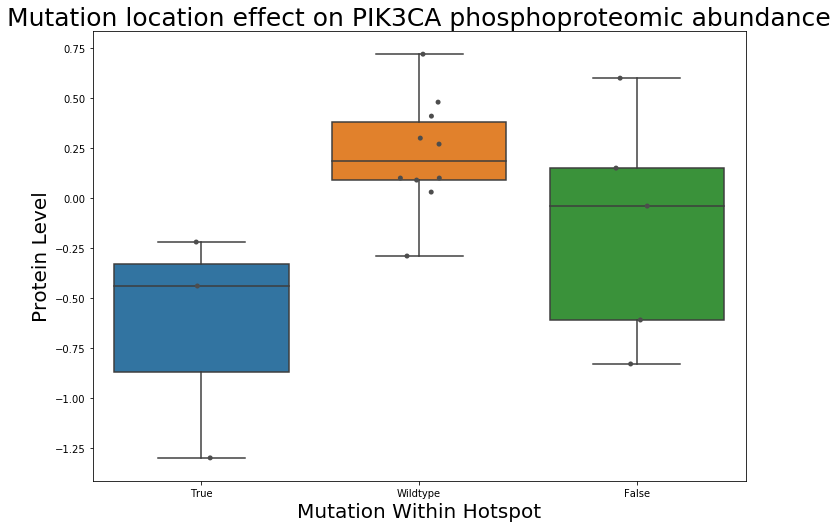

In [90]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize = a4_dims)
boxplt = sns.boxplot(data = p10_mutations, x = 'Within_Hotspot', y = 'PIK3CA-T313', ax = ax)
boxplt = sns.stripplot(data = p10_mutations, x = 'Within_Hotspot', y = 'PIK3CA-T313', jitter = True, color = '.3')
boxplt.set_title('Mutation location effect on PIK3CA phosphoproteomic abundance', fontsize='25')
boxplt.set_xlabel('Mutation Within Hotspot', fontsize='20')
boxplt.set_ylabel('Protein Level', fontsize='20')
plt.show()